In [6]:
library(rwwa)

y1 <- 1950
fittype <- "shift"

In [95]:
# fit linear GEV trend to all grid cells

df <- merge(read.table("gmst.dat", col.names = c("year", "gmst")), read.csv("era5_maxt2m_land.csv", skip = 2))
df <- df[df$year >= y1,]

models <- lapply(colnames(df)[-(1:2)], function (cnm) { tryCatch(fit_ns("gev", fittype, df[,c("year", "gmst", cnm)], cnm, "gmst"), error = function(cond) return(NULL)) })

npars <- length(models[[1]]$par)

# save model parameters
write.csv(sapply(models, function(mdl) if(is.null(unlist(mdl)[1])) return(rep(NA, npars)) else return(mdl$par)),
    paste0("fitted_",y1,"-2023_",fittype,"_model-pars.csv"))

In [ ]:
# save exceedances
xc = abind(sapply(models, function(mdl) if(is.null(unlist(mdl)[1])) return(matrix(nrow = nrow(df), ncol = 199)) else return((mdl$x - eff_return_level(mdl, 2:200)) > 0), simplify = F), along = 0)
save(xc, file = paste0("fitted_",y1,"-2023_",fittype,"_exceedances.Rdata"))

In [12]:
load(paste0("fitted_",y1,"-2023_",fittype,"_exceedances.Rdata"))
xc_counts <- apply(xc, 3, sum, na.rm = T) / (952*74)

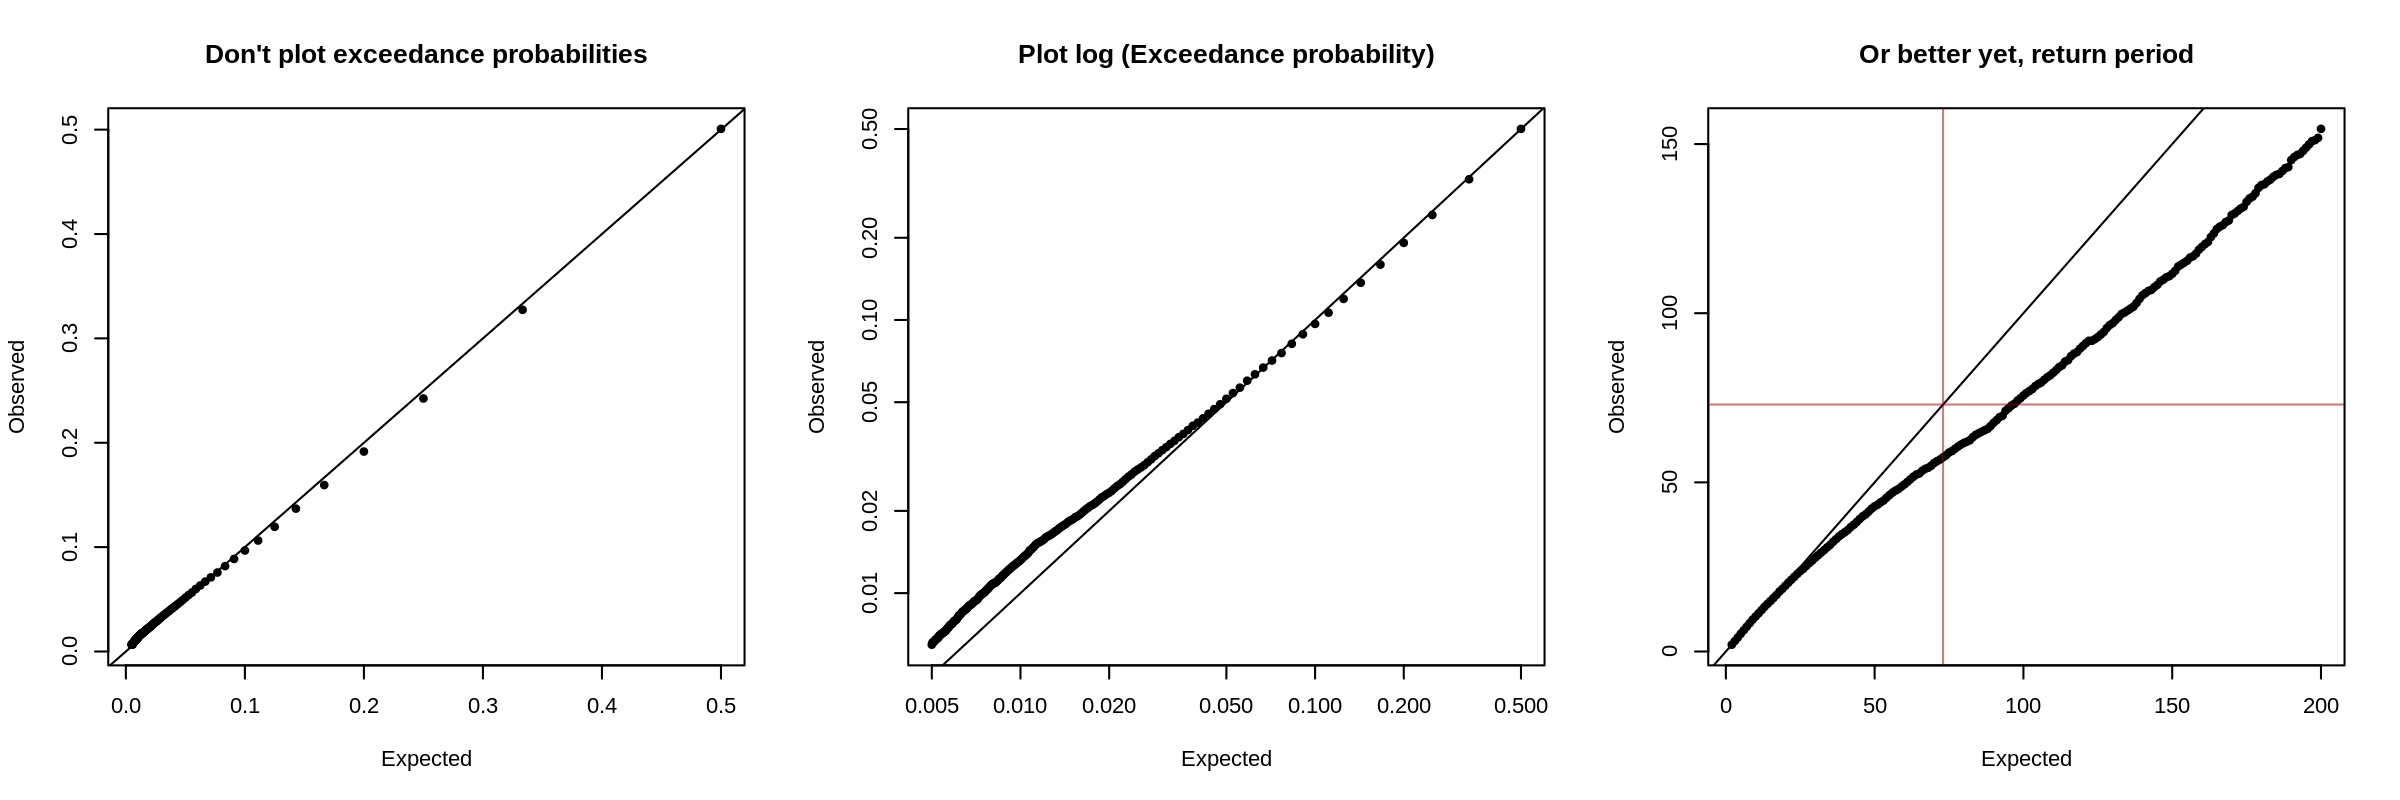

In [20]:
# important to plot exceedances on appropriate scales
prep_window(c(1,3))
plot(1/(2:200), xc_counts, xlab = "Expected", ylab = "Observed", log = "", main = "Don't plot exceedance probabilities")
abline(0,1)

plot(1/(2:200), xc_counts, xlab = "Expected", ylab = "Observed", log = "xy", main = "Plot log (Exceedance probability)")
abline(0,1)

plot(2:200, 1/xc_counts, xlab = "Expected", ylab = "Observed", main = "Or better yet, return period", log = "")
abline(0,1)
abline(h = 2023-y1, v = 2023-y1, col = adjustcolor("red4", 0.5))

In [36]:
annual_xc = data.frame("year" = y1:2023, "xc" = colSums(xc[,,51], na.rm = T))

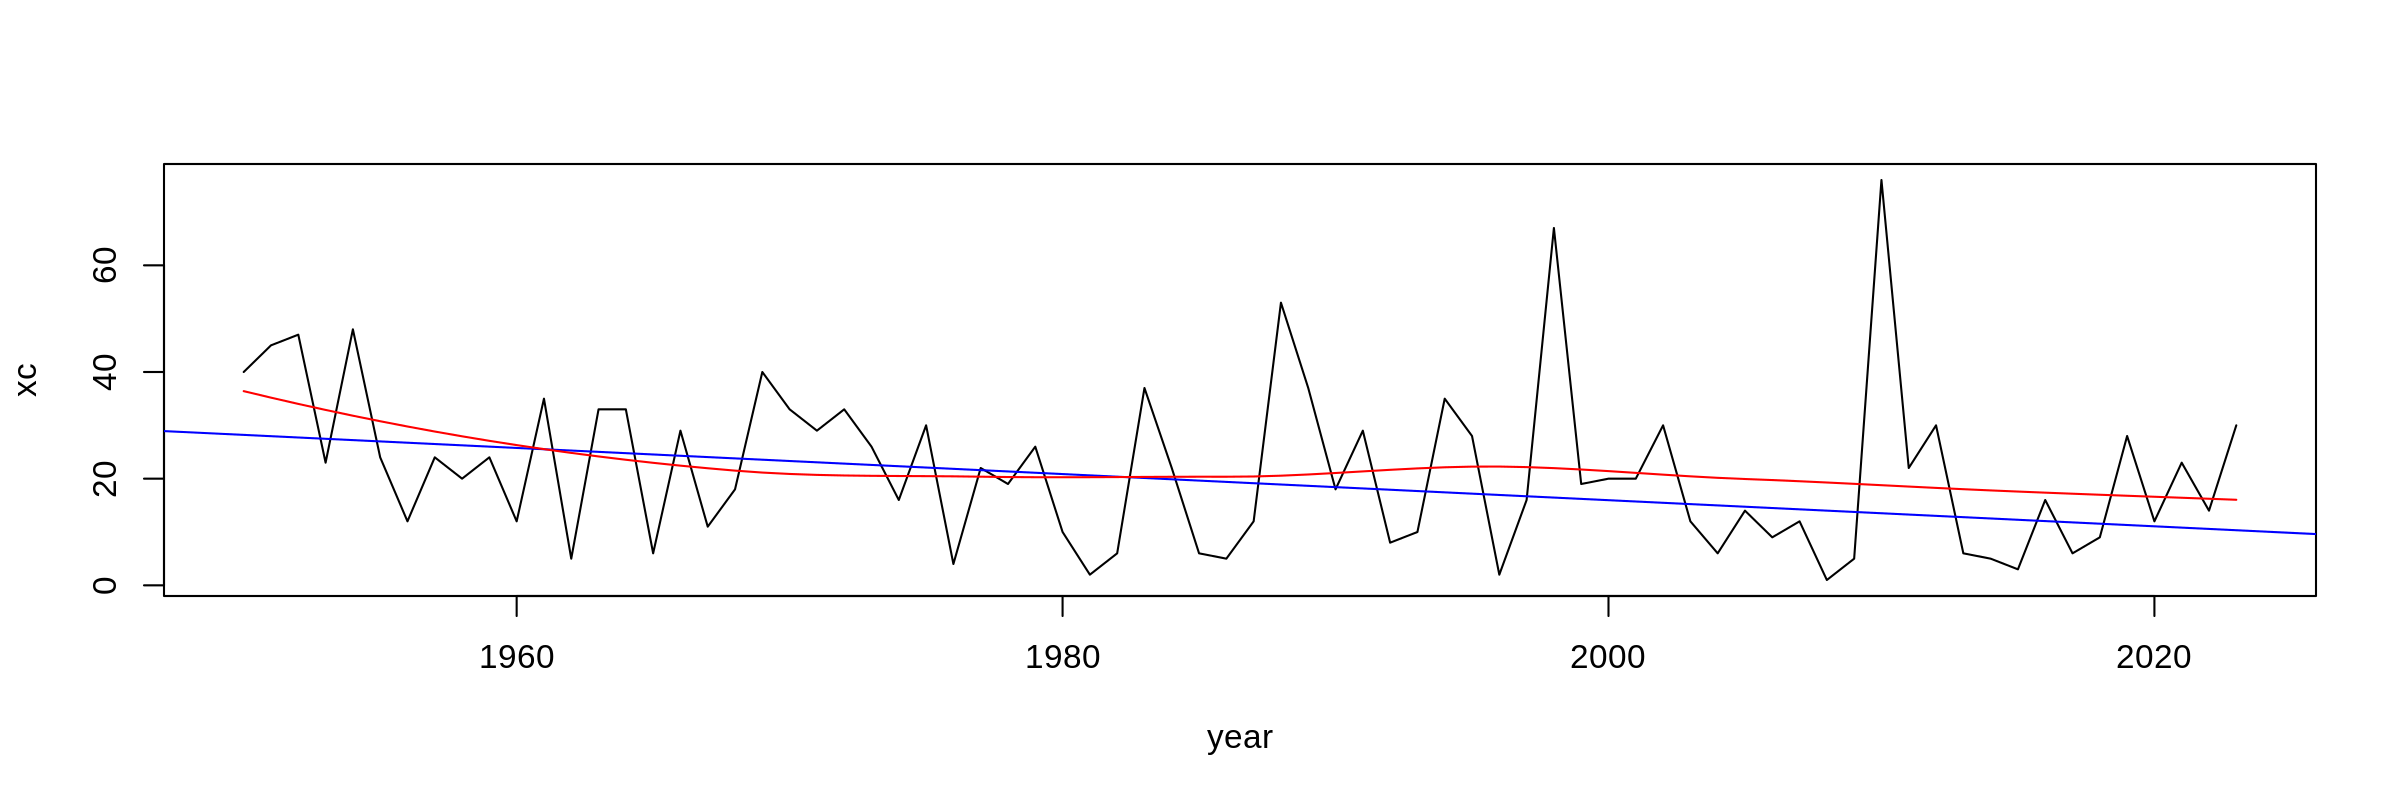

In [42]:
plot(annual_xc, type = "l")
abline(line(y1:2023, colSums(xc[,,51], na.rm = T)), col = "blue")
lines(y1:2023, fitted(loess(xc ~ year, annual_xc)), col = "red")

In [44]:
summary(lm(xc ~ year, annual_xc[annual_xc$year >= 1960,]))


Call:
lm(formula = xc ~ year, data = annual_xc[annual_xc$year >= 1960, 
    ])

Residuals:
    Min      1Q  Median      3Q     Max 
-19.194 -11.590  -2.402   9.098  57.629 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) 213.98750  202.07480   1.059    0.294
year         -0.09732    0.10146  -0.959    0.341

Residual standard error: 14.99 on 62 degrees of freedom
Multiple R-squared:  0.01462,	Adjusted R-squared:  -0.001271 
F-statistic:  0.92 on 1 and 62 DF,  p-value: 0.3412
